In [88]:
#install.packages("readxl")
#install.packages("dplyr")
library(readxl)
library(dplyr)


data = read_excel("C:/Users/maarc/Desktop/Teste/international_airline_activity_table1_2009tocurrent_1221.xlsx",col_names = TRUE, sheet = "Data")


In [89]:
#Passando os dados de "character" para "numérico"

data = as.data.frame(data)
data[,4:10]<- lapply(data[,4:10],as.numeric)
data[is.na(data)] <- 0


Warning message in lapply(data[, 4:10], as.numeric):
"NAs introduced by coercion"Warning message in lapply(data[, 4:10], as.numeric):
"NAs introduced by coercion"Warning message in lapply(data[, 4:10], as.numeric):
"NAs introduced by coercion"Warning message in lapply(data[, 4:10], as.numeric):
"NAs introduced by coercion"Warning message in lapply(data[, 4:10], as.numeric):
"NAs introduced by coercion"Warning message in lapply(data[, 4:10], as.numeric):
"NAs introduced by coercion"

In [90]:
## Busca de comportamentos sazonais na série histórica por meio da CWT (Continous Wavelet Transform)
# Contabilização de passageiros por mês, de 2009 a 2021 (13 Anos) (16120 células)

#install.packages("lubridate")
library(lubridate)
matriz = matrix(data = NA, ncol = 12, nrow = 13)
fita = matrix(data = NA,ncol = 7 ,nrow = 156)
PI = 0
FI = 0
MI = 0
PO = 0
FO = 0
MO = 0
contaano = 1
contames = 0
mesant = 1
#data[,1] = ymd(data[,1])
data[,1] = as.Date(data[,1],tryFormats = "%Y-%m-%d")


In [91]:
for (j in 2009:2021)
  {
    
    
    
    for (k in 1:12)
    {
      contames = contames+1
      
      
      
      for (i in 1: 16120)
      {
        
      
        mes = as.numeric(month(data[i,1]))
        ano = as.numeric(year(data[i,1]))
        
        if (mes == k && ano == j)
        {
          
          PI = PI + as.numeric(data[i,4])
          FI = FI + as.numeric(data[i,5])
          MI = MI + as.numeric(data[i,6])
          PO = PO + as.numeric(data[i,7])
          FO = FO + as.numeric(data[i,8])
          MO = MO + as.numeric(data[i,9])
          mesant = data[i,1] 
          
          
          
          
        }
        else
        {
          
          matriz[contaano,k] = PI
          fita[contames,1] = mesant
          fita[contames,2] = PI
          fita[contames,3] = FI
          fita[contames,4] = MI
          fita[contames,5] = PO
          fita[contames,6] = FO
          fita[contames,7] = MO
          
        }
        
     
      
      }
      
      if (i == 16120)
      {
        matriz[contaano,k] = PI
        fita[contames,1] = mesant
        fita[contames,2] = PI
        fita[contames,3] = FI
        fita[contames,4] = MI
        fita[contames,5] = PO
        fita[contames,6] = FO
        fita[contames,7] = MO
        
      }
      
      PI = 0
      FI = 0
      MI = 0
      PO = 0
      FO = 0
      MO = 0
      
    }
    contaano = contaano+1
  }
  
colnames(matriz) = c("Janeiro","Fevereiro","Março","Abril","Maio","Junho","Julho","Agosto","Setembro","Outubro","Novembro","Dezembro")
rownames(matriz) = seq(2009,2021)
colnames(fita) = c("Data","PI", "FI","MI","PO","FO","MO")


Starting wavelet transformation...
... and simulations... 
  |======================================================================| 100%
Class attributes are accessible through following names:
series loess.span dt dj Wave Phase Ampl Power Power.avg Power.pval Power.avg.pval Ridge Period Scale nc nr coi.1 coi.2 axis.1 axis.2 date.format date.tz 


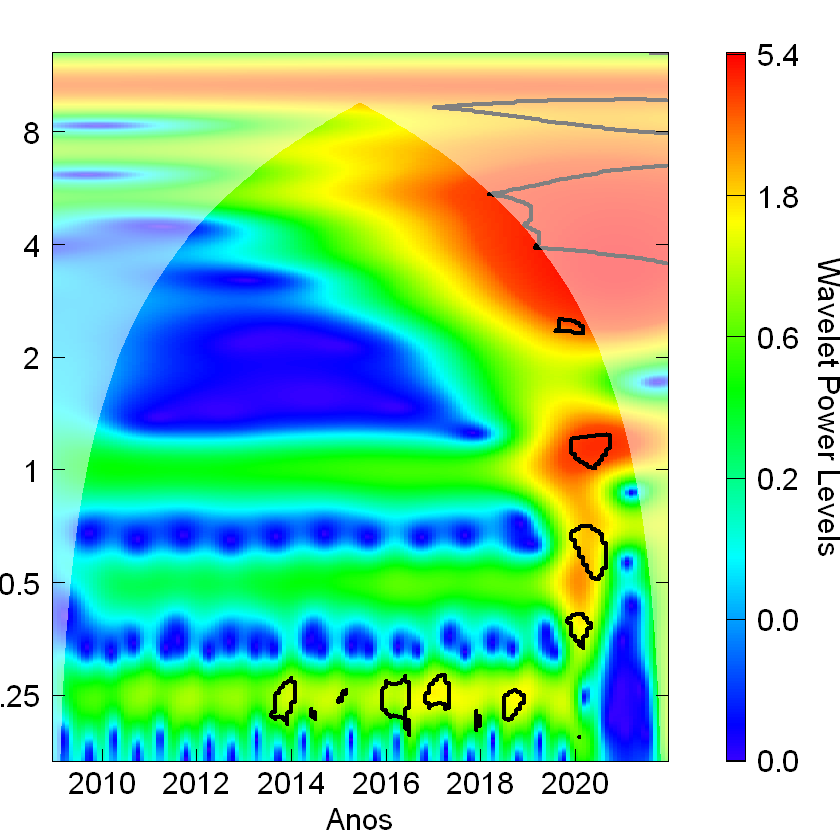

In [93]:
# Análise de sazonalidade por meio da CWT( Continous Wavelet Transform)

#install.packages("WaveletComp")
library(WaveletComp)
fita[,1] = seq(as.Date("2009/1/1"), as.Date("2021/12/31"),by = "month")
fita = as.data.frame(fita)
my.data <-data.frame(date = fita[,1], x1 = as.numeric(fita[,2]))
my.w <- analyze.wavelet(my.data, "x1",
                        loess.span = 0, 
                        dt = 1/12, dj = 1/100, upperPeriod = 13,
                        make.pval = TRUE, n.sim = 10,method = "AR")


par(mar = c(3,2,2,3)+0.1,cex.lab = 1.5,cex.axis = 1.5)

wt.image(my.w, exponent = 1, color.key = "quantile", n.levels = 250,
         plot.contour = TRUE, siglvl = 0.10,col.contour = "black",lwd = 3.5, plot.coi = TRUE,
         
         plot.ridge = FALSE, 
         color.palette = "rainbow(n.levels,start = 0, end = .7)", max.contour.segments = 1000000,
         legend.params = list(lab = "Wavelet Power Levels", n.ticks = 6,mar =5, lab.line = 3,shrink =1,label.digits = 1,width = 1),
         show.date = TRUE, date.format = "%Y-%m-%d", timelab = "Anos", periodlab = "Período (Meses)", periodtck = 0.01)




In [94]:

# Análise da existência tendências para cada mês (Mann-Kendall Modificado),a magnitude das mesmas (Curvatura de Sen) 
# e detecção de quebra de regime (Teste de Pettitt)

#install.packages("modifiedmk")
#install.packages("trend")
library(modifiedmk)
library(trend)
tendmes <-matrix(data = NA,nrow =6, ncol = 12,byrow = FALSE)

for (i in 1:12)
{
  
  MK<- as.list(mmkh(matriz[,i], ci = 0.95))
  peq<-pettitt.test(matriz[,i])
  tendmes[1,i]<- MK$`Corrected Zc`
  tendmes[2,i]<- MK$`new P-value`  

  
  if (MK$`new P-value`>=0.05)
  {
    tendmes[3,i]<-"NS"
    
  }
  
  else 
  {
      if (MK$`Corrected Zc`>0)
  {
    tendmes[3,i] = "S(+)"
  }
    else{
      tendmes[3,i]="S(-)"
    }
  }
  if (MK$`new P-value`== 1)
  {
    tendmes[3,i] = "ST"
  }
  
  
  tendmes[4,i]<-MK$`Sen's slope`

  tendmes[5,i]<-peq[["estimate"]][["probable change point at time K"]]
  tendmes[6,i]<-peq[["p.value"]]
}
rownames(tendmes) = c("Zc", "p-value (MMK)", "Significância", "senestimates","Ponto de Mudança","p-Value(PM)")
colnames(tendmes) = colnames(matriz)
tendmes

,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
Zc,3.23347104325878,2.74539994238953,1.76925774065103,2.01329329108566,1.89127551586835,2.80309255317834,1.89127551586835,2.01329329108566,1.89127551586835,1.89127551586835,2.01329329108566,2.01329329108566
p-value (MMK),0.00122295733275707,0.00604371940110762,0.0768508722678887,0.0440837837413209,0.0585875753104889,0.00506151418490704,0.0585875753104889,0.0440837837413209,0.0585875753104889,0.0585875753104889,0.0440837837413209,0.0440837837413209
Significância,S(+),S(+),NS,S(+),NS,S(+),NS,S(+),NS,NS,S(+),S(+)
senestimates,90710.375,69079.9166666667,66099.7857142857,70236.6,66217.7619047619,62324.1666666667,77213.4125,73971.8,66787.7,71466.5625,64344.5,73135.8
Ponto de Mudança,5,5,11,11,11,11,11,11,11,11,11,11
p-Value(PM),0.204091701087684,0.204091701087684,0.586114089685684,0.586114089685684,0.586114089685684,0.586114089685684,0.586114089685684,0.586114089685684,0.586114089685684,0.586114089685684,0.586114089685684,0.586114089685684



  There is a binary version available but the source version is later:
         binary source needs_compilation
forecast   8.14   8.16              TRUE

  Binaries will be installed


Warning message:
"package 'forecast' is in use and will not be installed"

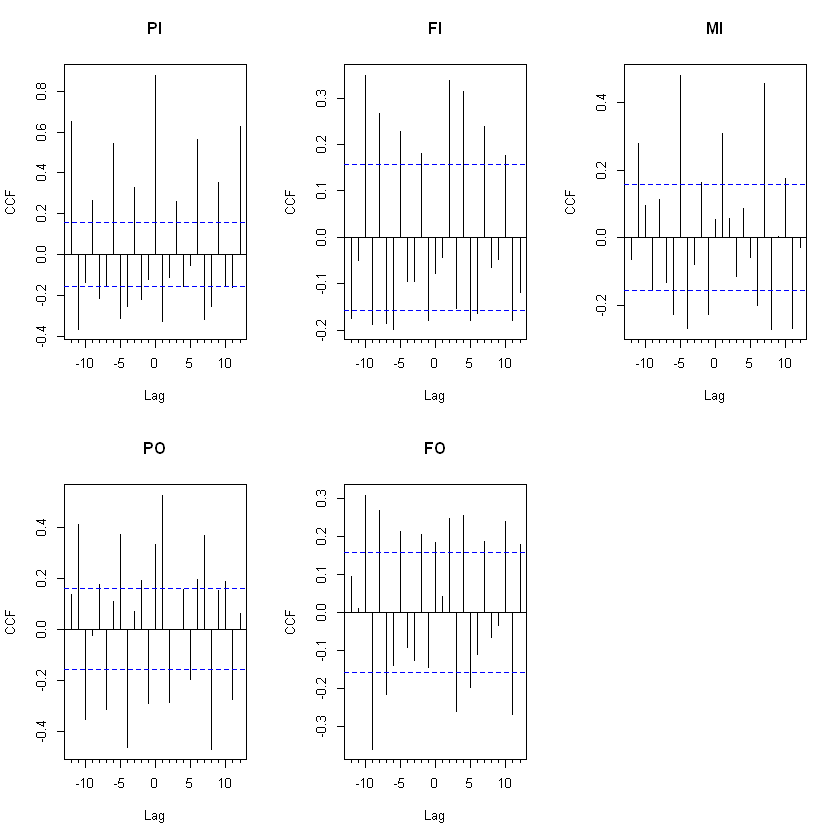

In [95]:
## Relacionamento entre a série histórica de entrada de passageiros e outras séries históricas

install.packages("forecast")
library(forecast)

par(mfrow = c(2,3))
nome = as.matrix(c("Data","PI", "FI","MI","PO","FO","MO"))
for(k in 2:6)
{
  #Determinando ARIMA para Série histórica de passageiros
  
x = auto.arima(as.numeric(fita[,2]))
  #Pré-branqueamento da série histórica de passageiros

pbx = x$residuals
#Pré-branqueamento das outras séries históricas

pby = stats::filter(as.numeric(fita[,k]), filter = c(1,-(1+coef(x)[1]),coef(x)[1]), sides =1)

#Correlação cruzada pós-branqueamento ded séries históricas

Ccf(pbx,pby,na.action=na.omit,main = nome[k,1],lag.max = 12)
}



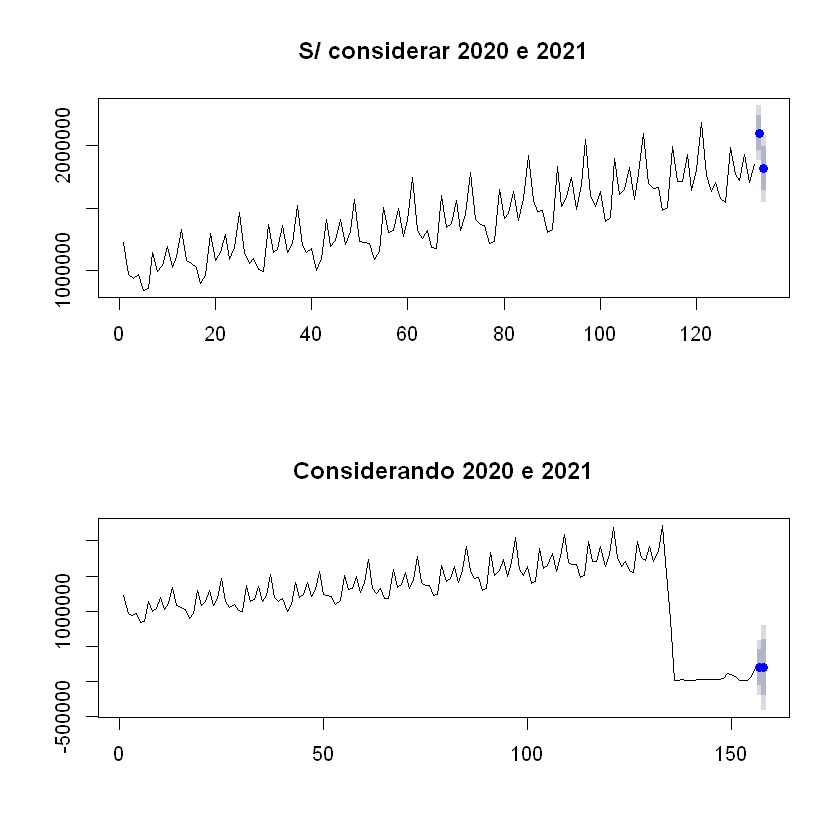

In [96]:
## Modelo preditor de número de passageiros para os próximos 6 meses: ARIMA

#Número de meses (t)
t = 2
par(mfrow = c(2,1))



# Caso não tivesse ocorrido a pandemia (Excluídos os anos de 2020 e 2021)
xnp = auto.arima(as.numeric(fita[1:132,2]))
coeficientes = arimaorder(xnp)
piarima <- Arima(as.numeric(fita[1:132,2]),order = c(coeficientes))
previsao <- forecast(piarima, h = t)
plot(previsao, main = "S/ considerar 2020 e 2021")


# Considerando efeitos da pandemia (Excluídos os anos de 2020 e 2021)
xcp = auto.arima(as.numeric(fita[,2]))
coeficientes = arimaorder(xcp)
piarima <- Arima(as.numeric(fita[,2]),order = c(coeficientes))
previsao <- forecast(piarima, h = t)
plot(previsao, main = "Considerando 2020 e 2021")


Países
Argentina
New Zealand
New Caledonia
Canada
China
Mauritius
Cook Islands
Germany
USA
Papua New Guinea


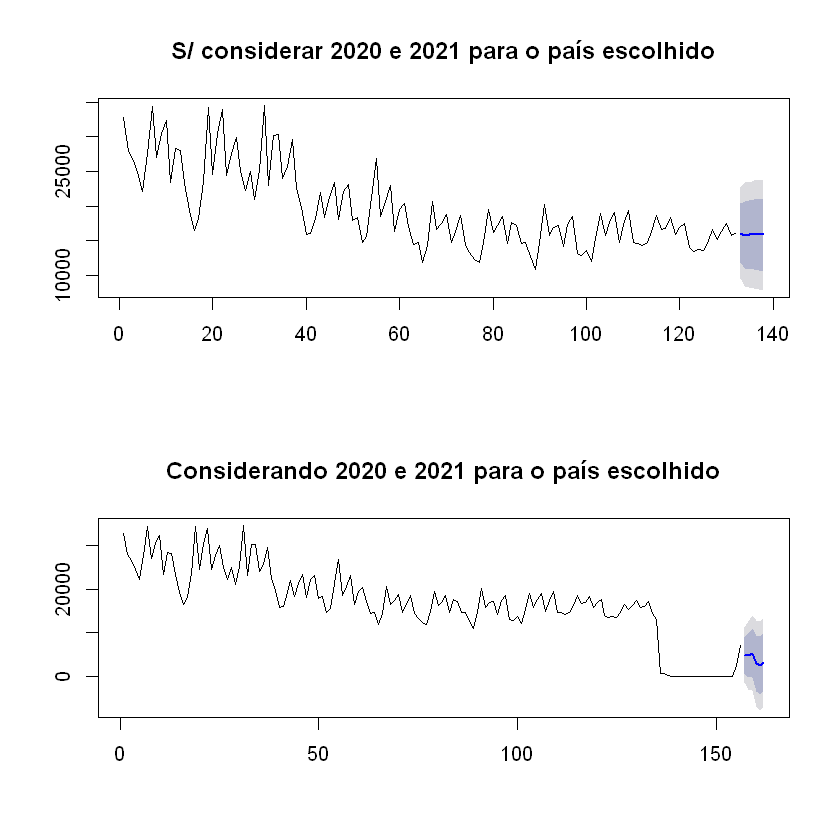

In [97]:
### Modelo preditor - Considerando países como continentes

# identificando os países que aparecem:


unicos = as.data.frame(unique(data[,3]))
colnames(unicos) = "Países"
unicos
#Escolha o país a ser analisado: Reino Unido, sigla "UK"

pais = "UK"

#Análise
contames = 0
origem = matrix(data = NA, ncol = 1,nrow = 156)

for (j in 2009:2021)
{
  
  
  
  for (k in 1:12)
  {
    contames = contames+1
    PI = 0
    
    for (i in 1: 16120)
    {
      
      
      mes = as.numeric(month(data[i,1]))
      ano = as.numeric(year(data[i,1]))
      paisanalisado = data[i,3]
  
        
      if (mes == k && ano == j && paisanalisado == pais)
      {
        
        PI = PI + as.numeric(data[i,4])
       
        
      }
      
      if (mes == k && ano == j && paisanalisado != pais)
      {
        
        PI = PI+0
        
        
      }
      
      if (mes != k)
      {
        
        origem[contames,1] = PI
        
        
      }
        
      
    }
    
    if (i == 16120)
    {
      
      #origem[contames,1] = mesant
      origem[contames,1] = PI
      
      
    }
          
  }
 
}

## Predição para o país escolhido


# Caso não tivesse ocorrido a pandemia (Excluídos os anos de 2020 e 2021)
par(mfrow = c(2,1))
xnp = auto.arima(as.numeric(origem[1:132,1]))
coeficientes = arimaorder(xnp)
piarima <- Arima(as.numeric(origem[1:132,1]),order = c(coeficientes))
previsao <- forecast(piarima, h = 6)
plot(previsao, main = "S/ considerar 2020 e 2021 para o país escolhido")


# Considerando efeitos da pandemia (Excluídos os anos de 2020 e 2021)
xcp = auto.arima(as.numeric(origem[,1]))
coeficientes = arimaorder(xcp)
piarima <- Arima(as.numeric(origem[,1]),order = c(coeficientes))
previsao <- forecast(piarima, h = 6)
plot(previsao, main = "Considerando 2020 e 2021 para o país escolhido")

